# Setup

This process is loosely based on this article: https://towardsdatascience.com/beyond-classification-with-transformers-and-hugging-face-d38c75f574fb

Attaching google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
project_path = ('/content/gdrive/My Drive/DATA_690_NLP/Text_Summarization/')
sys.path.append(project_path)

Mounted at /content/gdrive/


Installing hugging face package

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 13.3MB/s 
     |████████████████████████████████| 3.3MB 49.2MB/s 
     |████████████████████████████████| 901kB 48.7MB/s 


Importing necessary packages

In [3]:
import torch
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel, BertTokenizer
import seaborn as sns
sns.set()
% matplotlib inline
np.random.seed(42);

Miscellaneous package settings

In [4]:
model_name = "bert-base-uncased"
TOTAL_NO_LAYERS = 12
TOTAL_NO_ATTEN_HEADS = 12
CMAP = sns.light_palette("blue")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Loading pretrained BERT model and tokenizer

In [6]:
config = BertConfig.from_pretrained(model_name, output_attentions=True)
bert_model = BertModel.from_pretrained(model_name, config=config)
bert_model.eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

# Calculating Vector Representations for each Article

The idea here is to run each article through a pre-trained BERT model (https://huggingface.co/bert-base-uncased) that has been trained on massive amounts of data (https://yknzhu.wixsite.com/mbweb and https://en.wikipedia.org/wiki/English_Wikipedia). So the model already "knows" a lot about the structure of the English language, and this knowledge will be used to create a numerical representation of each article.

Because the articles are too long to input into the model, they had to be split into $p$ number of sentences using NLTK's `sent_tokenize` function. Each sentence output is represented by a matrix $S$ such that $S \in \mathbb{R}^{m \times n}$, where $m$ is the number of tokens in the sentence and $n$ is the number of features for each token. And then a vector is created to represent each sentence, by calculating the mean of each column:

$$
  s = S^T (mJ)^{-1}
$$

Where $J$ is a matrix of ones of dimensions $m \times 1$.

The vectors for each sentence then form a matrix representation of an article:

$$
A = (s^T_0\dots s^T_p)
$$

Where $A \in \mathbb{R}^{p \times n}$

And in order to create a vector representation of the entire article, the mean for each colum of the article matrix is calculated to create such vector:

$$
  a = A^T (pJ)^{-1}
$$

And the collection of this article vectors create a matrix representation of the set of artcles.

In [10]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

article_vectors = []

with torch.no_grad():
  for article in articles_df['Content'].values:

    sentence_tokens = sent_tokenize(article)

    sentence_vectors = []

    for index, sentence in enumerate(sentence_tokens):
      tokens = bert_tokenizer(sentence, return_tensors='pt', return_attention_mask=True).to(device)
      bert_model.to(device)
      output = bert_model(tokens.input_ids)

      sentence_matrix_representation = output.last_hidden_state.to('cpu').detach().numpy()[0]
      matrix_mean = np.mean(sentence_matrix_representation, axis=0).reshape((1, sentence_matrix_representation.shape[1]))
      sentence_vectors.append(matrix_mean)
      
    article_matrix_representation = np.array(sentence_vectors)
    article_matrix_representation = article_matrix_representation.reshape((article_matrix_representation.shape[0], article_matrix_representation.shape[2]))
    article_vector = np.mean(article_matrix_representation, axis=0)
    article_vector = article_vector.reshape((1, article_vector.shape[0]))
    article_vectors.append(article_vector)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
article_vectors = np.array(article_vectors)
article_vectors = article_vectors.reshape((article_vectors.shape[0], article_vectors.shape[2]))
print(article_vectors.shape)

(44, 768)


In [17]:
article_vectors_df = pd.DataFrame(article_vectors)
article_vectors_df.to_csv(f'{project_path}/Data/articles_latent_space.csv')

# Dimmensionality Reduction Using PCA

Used PCA (Principal Component Analysis) to reduce the number of dimmensions (size of the article vector representations) from 768 to 2 to be able to visualize the articles on a 2D Cartesian plane.

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix = pca.fit_transform(article_vectors)
print(matrix.shape)

(44, 2)


Plotted the results from the PCA calculation into a scatterplot, color-coding each dot based whether the article was published pre or post pandemic. And as you can see, there is no delineation between the two.

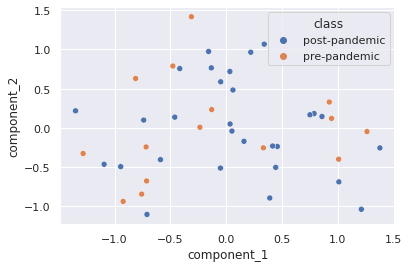

In [19]:
import datetime

components_df = pd.DataFrame({'component_1': matrix[:,0], 'component_2': matrix[:,1]})
components_df['year'] = pd.to_numeric(articles_df['Date Published'])
components_df['class'] = components_df['year'].apply(lambda x: 'pre-pandemic' if x < 2020 else 'post-pandemic')
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=components_df, x='component_1', y='component_2', hue='class', ax=ax)

Since the articles did not cluster by date of publication, I used DBSCAN to see what kind of clusters were created. I tried different values for $\epsilon$, which determines the distance between to dots to be considered as the same cluster, and saw that 0.45 produced the most pronounced clusters.

I also tried different metrics, including cityblock, cosine, L1, L2, and manhattan. But decided to go with euclidean.

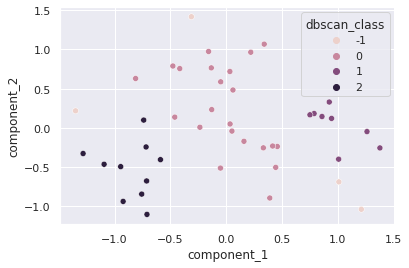

In [20]:
from sklearn.cluster import DBSCAN

dbscan_clusters = DBSCAN(eps=0.45, metric='euclidean').fit_predict(matrix)
components_df['dbscan_class'] = dbscan_clusters
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=components_df, x='component_1', y='component_2', hue='dbscan_class', ax=ax)

# Dimmensionality Reduction Using t-SNE

I also tried t-SNE (t-distributed Stochastic Neighbor Embedding) to visualize the list of vector respresentations, using a relatively low perplexity value since the size of the data is small.

In [74]:
from sklearn.manifold import TSNE

matrix_embedded = TSNE(n_components=2, perplexity=7).fit_transform(article_vectors)
print(matrix_embedded.shape)

(44, 2)


Plotted the results and color-coded based on publication date, but didn't see any speration between pre and post pandemic here either.

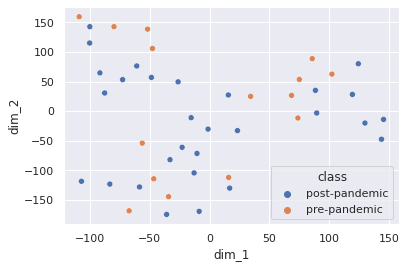

In [75]:
embedded_df = pd.DataFrame({'dim_1': matrix_embedded[:,0], 'dim_2': matrix_embedded[:,1]})
embedded_df['year'] = pd.to_numeric(articles_df['Date Published'])
embedded_df['class'] = embedded_df['year'].apply(lambda x: 'pre-pandemic' if x < 2020 else 'post-pandemic')
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=embedded_df, x='dim_1', y='dim_2', hue='class', ax=ax)

Used DBSCAN on the t-SNE results and was able to identify more pronounced clusters than the ones produced by PCA.

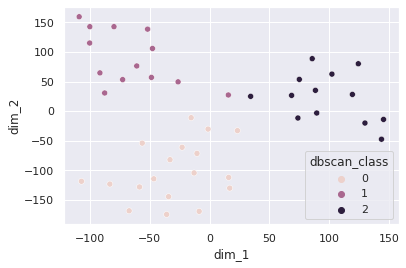

In [79]:
dbscan_clusters_embedded = DBSCAN(eps=50, metric='euclidean').fit_predict(matrix_embedded)
embedded_df['dbscan_class'] = dbscan_clusters_embedded
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=embedded_df, x='dim_1', y='dim_2', hue='dbscan_class', ax=ax)